## Homework 4

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv -O data.csv

--2021-10-04 21:05:47--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 178,21K  --.-KB/s    in 0,1s    

2021-10-04 21:05:47 (1,51 MB/s) - ‘data.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('data.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
numerical = [
    'seniority',
    'time',
    'age',
    'expenses',
    'income',
    'assets',
    'debt',
    'amount',
    'price'
    ]

categorical = [
    'home',
    'marital',
    'records',
    'job',
]

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [10]:
for n_var in numerical:
    score = roc_auc_score(df_train['default'], df_train[n_var])
    if (score<0.5):
        print(n_var, '(negative)')
        score = roc_auc_score(df_train['default'], -df_train[n_var])
    else:
        print(n_var)
    
    print(score)

seniority (negative)
0.7093778624491943
time
0.5608662489595051
age (negative)
0.5732933272499939
expenses (negative)
0.5009184217217011
income (negative)
0.682006666132633
assets (negative)
0.6486042567122802
debt (negative)
0.5047829675783548
amount
0.5910773431595518
price
0.5043329862114843


Which numerical variable (among the following 4) has the highest AUC?

- **seniority**
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [11]:
df_feature = ['seniority', 'income', 'assets', 'records', 'job', 'home']

df_train_n = df_train[df_feature]
df_val_n = df_val[df_feature]
df_test_n = df_test[df_feature]

dv = DictVectorizer(sparse=False)

dict_train = df_train_n.to_dict(orient='records')
dict_val = df_val_n.to_dict(orient='records')
dict_test = df_test_n.to_dict(orient='records')

X_train = dv.fit_transform(dict_train)
X_val = dv.fit_transform(dict_val)
X_test = dv.fit_transform(dict_test)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

In [12]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_val)[:, 1]

print(round(roc_auc_score(y_val, y_pred), 3))

0.812


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- **0.812**

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

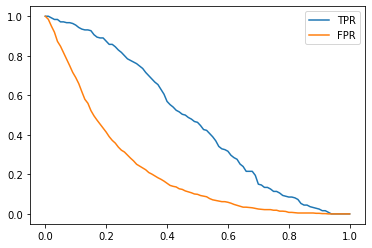

In [13]:
scores = []
thresholds = np.linspace(0, 1, 101)
y_pred_proba = lr.predict_proba(X_val)[:, 1]

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred_proba >= t)
    predict_negative = (y_pred_proba < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [14]:
print(df_scores[df_scores['tpr'] == df_scores['fpr']])

     threshold   tp   fp   fn   tn  tpr  fpr
0         0.00  246  645    0    0  1.0  1.0
94        0.94    0    0  246  645  0.0  0.0
95        0.95    0    0  246  645  0.0  0.0
96        0.96    0    0  246  645  0.0  0.0
97        0.97    0    0  246  645  0.0  0.0
98        0.98    0    0  246  645  0.0  0.0
99        0.99    0    0  246  645  0.0  0.0
100       1.00    0    0  246  645  0.0  0.0


At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* **0.8**

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [15]:
f1_score = []

for i, r in df_scores.iterrows():
    precision = r.tp / (r.tp + r.fp)
    recall = r.tp / (r.tp + r.fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_score.append(f1)

df_scores['f1'] = f1_score
df_scores[df_scores['f1'] == df_scores['f1'].max()]


/tmp/ipykernel_8684/3736754614.py:4: RuntimeWarning: invalid value encountered in double_scalars
  precision = r.tp / (r.tp + r.fp)


,threshold,tp,fp,fn,tn,tpr,fpr,f1
30,0.3,187,162,59,483,0.760163,0.251163,0.628571


At which threshold F1 is maximal?

- 0.1
- **0.3**
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [16]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[df_feature].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [17]:
def predict(df, dv, model):
    dicts = df[df_feature].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train_f = df_full_train.iloc[train_idx]
    df_val_f = df_full_train.iloc[val_idx]

    y_train = df_train_f.default.values
    y_val = df_val_f.default.values

    dv, model = train(df_train_f, y_train, 1)
    y_pred = predict(df_val_f, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(round(np.std(scores), 3))

0.014


How large is standard devidation of the scores across different folds?

- 0.001
- **0.014**
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [19]:
C = [0.01, 0.1, 1, 10]

for c in C:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_f = df_full_train.iloc[train_idx]
        df_val_f = df_full_train.iloc[val_idx]

        y_train = df_train_f.default.values
        y_val = df_val_f.default.values

        dv, model = train(df_train_f, y_train, c)
        y_pred = predict(df_val_f, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.812 +- 0.014
C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- **10**

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C